In [1]:
import pandas as pd 
import git
import numpy as np
import geopandas as gpd
import plotly as px
import networkx as nx
from datetime import datetime as dt
from vehicle_stream_pipeline.utils import get_shortest_ride, get_hotspots, calculate_drives, calculate_graph, add_drone_flights, poi_poly, generateRideSpecs, find_id_for_name

repo = git.Repo(".", search_parent_directories=True).git.rev_parse(
    "--show-toplevel")

In [2]:
drives = pd.read_csv(f"{repo}/data/cleaning/data_cleaned.csv")
drives = drives[(drives["state"] == "completed")]
edges = pd.read_excel(f"{repo}/data/other/MoDstops+Preismodell.xlsx", sheet_name= 'Liste 2022')

/var/folders/gb/hn_j3jkn5_5fm5ylgtcd9w_00000gn/T/ipykernel_42574/3440087016.py:1: DtypeWarning: Columns (44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  drives = pd.read_csv(f"{repo}/data/cleaning/data_cleaned.csv")


In [99]:
df_stops = pd.read_excel(
    f"{repo}/data/other/MoDstops+Preismodell.xlsx", sheet_name='MoDstops')

In [100]:
startdate = drives.scheduled_to.min()
startdate = dt.strptime(startdate, '%Y-%m-%d %H:%M:%S')
startdate = startdate.strftime('%m/%d/%Y')
start_date = dt.strptime(startdate, "%m/%d/%Y")
enddate = drives.scheduled_to.max()
enddate = dt.strptime(enddate, '%Y-%m-%d %H:%M:%S')
enddate = enddate.strftime('%m/%d/%Y')
end_date = dt.strptime(enddate, "%m/%d/%Y")

In [101]:
drives_w_simulation = pd.DataFrame(columns=drives.columns)
new_rides_all = pd.DataFrame(columns=drives.columns)
for i in range(1, 13):
    new_rides = generateRideSpecs(drives, drives_w_simulation, df_stops, edges, 10000, i, 2021)
    new_rides_all = pd.concat([new_rides, new_rides_all])

new_rides_all["simulated"] = True
drives["simulated"] = False

new_rides_all = pd.concat([drives, new_rides_all])



In [141]:
drives["new"] = drives["pickup_address"].astype(str) +"_"+ drives["dropoff_address"].astype(str)

In [142]:
drives["new"]

0        11009_6004
2        10003_6004
6         1009_5002
7        6004_10003
8         5002_9010
            ...    
18945    1008_12008
18952     7001_1009
18959     1009_3013
18960    4037_12007
18961    16027_1009
Name: new, Length: 9002, dtype: object

In [102]:
new_rides_all[new_rides_all["simulated"] == True]

,id,user_id,distance,number_of_passenger,price_operations,price_offer,price_payed,free_ride,payment_type,pickup_address,dropoff_address,state,created_from_offer,created_at,scheduled_to,dispatched_at,pickup_arrival_time,arriving_push,vehicle_arrived_at,earliest_pickup_expectation,pickup_first_eta,pickup_eta,pickup_at,dropoff_first_eta,dropoff_eta,dropoff_at,updated_at,arrival_deviation,waiting_time,boarding_time,ride_time,trip_time,shortest_ridetime,delay,longer_route_factor,arrival_indicator,rating,rating_puenktlichkeit,rating_sauberkeit,rating_fahrer,rating_find_modstop,rating_other_comments,cancellation_reason,cancellation_comment,bahn_card_number,year_card_type,year_card_number,canceled_at,rating_question_one,rating_question_two,index,simulated
0,1657533122-0,0-1657533122,2785.0,1.0,NaN,NaN,NaN,False,STANDARD,1008,6004,completed,NaN,2021-12-01 14:58:08,2021-12-01 14:58:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.2,NaN,NaN,Gelbes Signalschild,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,1657533122-1,1-1657533122,2833.0,1.0,NaN,NaN,NaN,False,VRN,9005,9017,completed,NaN,2021-12-01 15:42:11,2021-12-01 15:42:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,339.96,NaN,NaN,Kein Signalschild,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,1657533122-2,2-1657533122,NaN,1.0,NaN,NaN,NaN,False,STANDARD,1008,1008,completed,NaN,2021-12-01 17:36:28,2021-12-01 17:36:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kein Signalschild,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,1657533122-3,3-1657533122,733.0,1.0,NaN,NaN,NaN,False,BAHN_CARD,1007,1009,completed,NaN,2021-12-01 10:11:09,2021-12-01 10:11:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.96,NaN,NaN,Kein Signalschild,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,1657533122-4,4-1657533122,2782.0,1.0,NaN,NaN,NaN,False,BAHN_CARD,1009,8002,completed,NaN,2021-12-01 11:14:02,2021-12-01 11:14:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333.84,NaN,NaN,None,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1657533090-9995,9995-1657533090,6585,2.0,NaN,NaN,NaN,True,VRN,14009,3018,completed,NaN,2021-01-31 10:22:41,2021-01-31 10:22:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,790.2,NaN,NaN,Kein Signalschild,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
9996,1657533090-9996,9996-1657533090,4208,1.0,NaN,NaN,NaN,False,BAHN_CARD,6004,5002,completed,NaN,2021-01-31 17:56:12,2021-01-31 17:56:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,504.96,NaN,NaN,Kein Signalschild,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
9997,1657533090-9997,9997-1657533090,6585,1.0,NaN,NaN,NaN,False,BAHN_CARD,14009,3018,completed,NaN,2021-01-31 10:45:18,2021-01-31 10:45:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,790.2,NaN,NaN,Kein Signalschild,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
9998,1657533090-9998,9998-1657533090,2155,2.0,NaN,NaN,NaN,False,VRN,5010,4025,completed,NaN,2021-01-31 15:04:41,2021-01-31 15:04:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.6,NaN,NaN,Kein Signalschild,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [124]:
aggregated_drives = calculate_drives(drives, start_date, end_date).reset_index()
aggregated_drives_sim = calculate_drives(new_rides_all, start_date, end_date).reset_index()

In [125]:
aggregated_drives

,index,pickup_address,dropoff_address,number_of_drives,waiting_time,avg_ride_time,avg_time_to_destination
0,0,1001,1004,5,67.000000,0.001738,67.001738
1,1,1001,1005,19,17.631579,0.001543,17.633122
2,2,1001,1007,2,167.500000,0.002882,167.502882
3,3,1001,1008,3,111.666667,0.003538,111.670204
4,4,1001,1012,2,167.500000,0.005694,167.505694
...,...,...,...,...,...,...,...
3313,3313,18005,11003,1,335.000000,0.001921,335.001921
3314,3314,18005,12001,1,335.000000,0.010741,335.010741
3315,3315,18005,12006,1,335.000000,0.010486,335.010486
3316,3316,18005,12008,1,335.000000,0.017095,335.017095


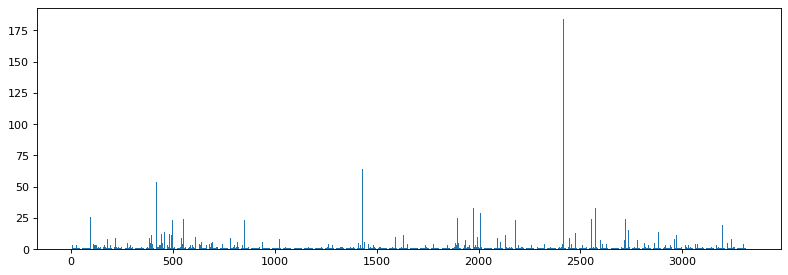

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4), dpi=80)
plt.bar(aggregated_drives["index"],aggregated_drives["number_of_drives"])

plt.show()

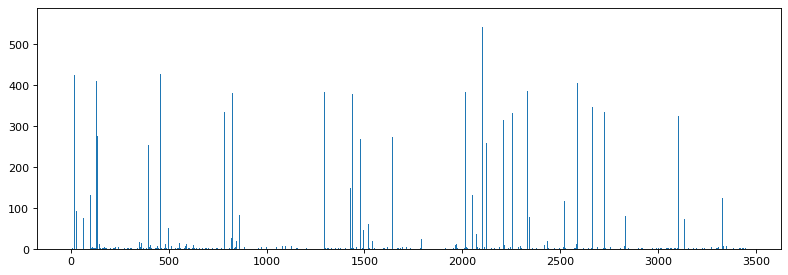

In [133]:

plt.figure(figsize=(12, 4), dpi=80)
plt.bar(aggregated_drives_sim["index"],aggregated_drives_sim["number_of_drives"])
plt.show()

In [134]:
aggregated_drives_sim[aggregated_drives_sim["pickup_address"] == aggregated_drives_sim["dropoff_address"]]

,index,pickup_address,dropoff_address,number_of_drives,waiting_time,avg_ride_time,avg_time_to_destination
386,386,1008,1008,447,0.749441,NaN,NaN
2103,2103,7001,7001,541,0.619224,NaN,NaN


In [103]:
len(new_rides_all[(new_rides_all["pickup_address"] == 1007) & (new_rides_all["dropoff_address"] == 4037)])

3

In [104]:
len(drives[(drives["pickup_address"] == 1007) & (drives["dropoff_address"] == 4037)])

3

In [144]:
find_id_for_name("Rathaus Hambach", df_stops)

4025

In [106]:
graph_sim = calculate_graph(aggregated_drives_sim)
graph = calculate_graph(aggregated_drives)

In [7]:
hotspots = get_hotspots(edges, aggregated_drives)

/usr/local/lib/python3.9/site-packages/vehicle_stream_pipeline/utils.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edges_filtered["Spots"] = df_edges_filtered.apply(


In [8]:
hotspots = [spot[0] for spot in hotspots]

In [9]:
hotspots

[1008, 4025, 1005, 1009, 1007, 12007, 7001, 6004, 1010, 11017]

In [66]:
hotspots = [1008, 4025, 1005, 1009, 1007, 12007, 7001, 6004, 1010, 11017]
drone_spots = [15011, 13001, 2002, 11007, 4016, 1002, 3020, 9019, 9005]

In [9]:
graph_with_drones = calculate_graph(drives_w_flights)

In [107]:
result1, a = get_shortest_ride(1001, 10001, graph)
result2, b = get_shortest_ride(1001, 10001, graph_sim)

In [55]:
result1

[1001, 1005, 3001, 4025, 1008, 4038, 10001]

In [56]:
result2

[1001, 1005, 4025, 1008, 4038, 10001]

In [109]:
b

230.16171182609753